<span style="color:black;font-size:35px">**Ibrahim Fish Dataset**</span>

In [18]:
CWD = r'C:\Users\Evant\Desktop\cis472\latest\CIS472-CourseProject'
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms as T
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
from tqdm import tqdm
import sys
sys.path.append(CWD+r'\models')
# sys.path.append(r'C:\Users\hansm\Github\CIS472-CourseProject\models')
from vgg import VGG16
from lenet import LeNet
from alexnet import AlexNet
sys.path.pop()
#sys.path.append(r'..\training')
# sys.path.append(r'C:\Users\hansm\Github\CIS472-CourseProject\training')
# from training import train_epoch
# sys.path.pop()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

FILEPATH = r"..\..\FISH0006 fishclassifierfinal\intel-image-classification"
# FILEPATH = r"C:\Users\hansm\Github\CIS472-CourseProject\Project Datasets\Dataset3\FishClassifierFinal\archive\intel-image-classification"

In [2]:
def evaluate(model, test_data):
    model.eval()
    accuracy = 0
    with torch.no_grad():
        for (data, label) in test_data:
#             print(data)
            data = data.to(device)
#             label = torch.tensor(label)
#             print(label)
            label = label.to(device)
            out = model(data)
            answers = out.max(dim=1)[1]
#             answers = torch.max(out, dim=1)
#             print(answers)
            accuracy += (answers == label).sum()
    return accuracy

In [3]:
def train_epoch(model, train_data, LossFunction, optimizer):
#     model.to(device)
    model.train()
    loss_history = []
    acc_history = []
    correct = 0
    for (data, label) in tqdm(train_data, desc="iteration", unit="%", disable=True):
        # clear the gradients
        optimizer.zero_grad(set_to_none=True)
        
        # send the data and labels to the same device as the training model
        data = data.to(device)
#         print(label.shape)
        label = label.to(device)

        # get the output from the model
        out = model(data)
#         print(out.shape)
        _, output = torch.max(out, 1)
        
        # calculate loss
        loss = LossFunction(out, label)
        
        # calculate gradients and perform gradient descent
        loss.backward()
        optimizer.step()
        correct += (output == label).float().sum()
        loss_history.append(loss.item())
    accuracy = 100 * correct / len(fish_train_set)
    return loss_history, accuracy

In [4]:
# not really useful at the moment
class My_Dataset(Dataset):
    def __init__(self, data_path, transform=None):
        raise NotImplementedError
        
    def __len__(self):
        raise NotImplementedError
        
    def __getitem__(self, idx):
        raise NotImplementedError

In [5]:
class FishDataset(Dataset):
    def __init__(self, data_path, train=False, shuffle=False, transform=None):
        self.train = train
        self.transform = transform
        self.data_path = data_path
        datapoints = {}
        i = 0
        if train:
            for label in os.listdir(fr"{data_path}\seg_train\seg_train"):
                for image in os.listdir(fr"{data_path}\seg_train\seg_train\{label}"):
                    datapoints[image] = i
                i += 1
        else:
            for label in os.listdir(fr"{data_path}\seg_test\seg_test"):
                for image in os.listdir(fr"{data_path}\seg_test\seg_test\{label}"):
                    datapoints[image] = i
                i += 1
        self._num_labels = i
        if shuffle:
            k = list(datapoints.keys())
            random.shuffle(k)
            l = [(key, datapoints[key]) for key in k]
            datapoints = dict(l)
        self.labels = list(datapoints.values())
        self.images = list(datapoints.keys())
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        folders = os.listdir(fr"{self.data_path}\seg_train\seg_train")
        label = self.labels[idx]
        if self.train:
            img = Image.open(fr"{self.data_path}\seg_train\seg_train\{folders[label]}\{self.images[idx]}")
        else:
            img = Image.open(fr"{self.data_path}\seg_test\seg_test\{folders[label]}\{self.images[idx]}")
        # this data set contains a number of png files with an alpha channel
        img = img.convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
#         if not img.shape[0] == 3:
#             print(img.shape)
#             img = img.convert("RGB")
#             img.cv2.cvtColor(img, cv2.COLOR_BGRA)
        return img, label    

    def num_labels(self):
        return self._num_labels

In [6]:
fish_transform = T.Compose([T.Resize(size=(32,32)), 
                            T.RandomHorizontalFlip(), 
                            T.ToTensor(), 
                            T.Normalize(mean=[0.485, 0.456, 0.406], 
                                        std=[0.229, 0.224, 0.225])])

fish_train_set = FishDataset(FILEPATH, 
                             train=True, 
                             shuffle=True, 
                             transform=fish_transform)
fish_test_set = FishDataset(FILEPATH, 
                            train=False, 
                            shuffle=True, 
                            transform=fish_transform)

Type: <class 'list'>
Length: 2
More Types: <class 'torch.Tensor'>, <class 'torch.Tensor'>
Image Shapes: torch.Size([3, 32, 32]), torch.Size([3, 32, 32])
Labels: tensor([24, 11])



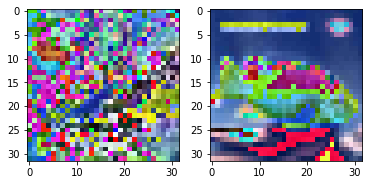

In [7]:
fish_investigation_dataset = DataLoader(fish_train_set, batch_size=2)
fish_data = iter(fish_investigation_dataset)
fish_single_point = next(fish_data)
print(f"""Type: {type(fish_single_point)}
Length: {len(fish_single_point)}
More Types: {type(fish_single_point[0])}, {type(fish_single_point[1])}
Image Shapes: {fish_single_point[0][0].shape}, {fish_single_point[0][1].shape}
Labels: {fish_single_point[1]}
""")

ToPIL = T.ToPILImage()
img0 = ToPIL(fish_single_point[0][0])
img1 = ToPIL(fish_single_point[0][1])
fi_1, axs_1 = plt.subplots(1,2)
axs_1[0].imshow(img0)
axs_1[1].imshow(img1)

<span style="color:black;font-size:35px">**VGG Training**</span>

In [8]:
vgg_learning_rate = 1e-1
vgg_nepochs = 20
fish_batch_size = 64

fish_train_dataset = DataLoader(fish_train_set, batch_size=fish_batch_size)
fish_test_dataset = DataLoader(fish_test_set, batch_size=fish_batch_size)

loss_function = nn.CrossEntropyLoss()

In [35]:
vgg = VGG16(hidden_features=512, nout=30, dropout=False).to(device)
# print(vgg)

vgg_optimizer_sgd = optim.SGD(vgg.parameters(), lr=vgg_learning_rate)

loss_function = nn.CrossEntropyLoss()

vgg.train()
vgg_loss_history = []
vgg_train_acc_history = []
vgg_test_acc_history = []
for epoch in tqdm(range(vgg_nepochs),
                  desc=f"Epoch",
                  unit="epoch",
                  disable=False):
#     vgg_loss_history.append
    loss_history, accuracy = (train_epoch(model=vgg, 
                                        train_data=fish_train_dataset, 
                                        LossFunction=loss_function, 
                                        optimizer=vgg_optimizer_sgd))
    vgg_loss_history.append(loss_history)
    vgg_train_acc_history.append(accuracy)
    vgg_test_acc_history.append((evaluate(vgg, fish_test_dataset) / len(fish_test_set)) * 100)

    print(f"Epoch {epoch}:\ntrain loss: {vgg_loss_history[-1][-1]}"
          f"\ntrain acc:  {float(vgg_train_acc_history[-1])} test acc: {float(vgg_test_acc_history[-1])}")

Epoch:   5%|███▋                                                                     | 1/20 [00:28<08:59, 28.41s/epoch]

Epoch 0:
train loss: 2.342909574508667
train acc:  17.547739028930664 test acc: 22.28318214416504


Epoch:  10%|███████▎                                                                 | 2/20 [00:57<08:36, 28.70s/epoch]

Epoch 1:
train loss: 1.6503775119781494
train acc:  34.93467330932617 test acc: 37.49736404418945


Epoch:  15%|██████████▉                                                              | 3/20 [01:27<08:17, 29.27s/epoch]

Epoch 2:
train loss: 1.46367347240448
train acc:  48.743717193603516 test acc: 40.93690490722656


Epoch:  20%|██████████████▌                                                          | 4/20 [01:55<07:44, 29.03s/epoch]

Epoch 3:
train loss: 1.047526478767395
train acc:  57.809043884277344 test acc: 47.03523635864258


Epoch:  25%|██████████████████▎                                                      | 5/20 [02:24<07:15, 29.03s/epoch]

Epoch 4:
train loss: 0.690542995929718
train acc:  64.18090057373047 test acc: 49.39860534667969


Epoch:  30%|█████████████████████▉                                                   | 6/20 [02:53<06:42, 28.76s/epoch]

Epoch 5:
train loss: 0.7231730222702026
train acc:  70.51256561279297 test acc: 53.36568832397461


Epoch:  35%|█████████████████████████▌                                               | 7/20 [03:21<06:11, 28.57s/epoch]

Epoch 6:
train loss: 0.4805915951728821
train acc:  74.25125885009766 test acc: 58.00801467895508


Epoch:  40%|█████████████████████████████▏                                           | 8/20 [03:49<05:41, 28.46s/epoch]

Epoch 7:
train loss: 0.2482481747865677
train acc:  79.51758575439453 test acc: 62.945770263671875


Epoch:  45%|████████████████████████████████▊                                        | 9/20 [04:19<05:18, 28.95s/epoch]

Epoch 8:
train loss: 0.3624464273452759
train acc:  83.35678100585938 test acc: 64.8871078491211


Epoch:  50%|████████████████████████████████████                                    | 10/20 [04:48<04:48, 28.83s/epoch]

Epoch 9:
train loss: 0.2704249322414398
train acc:  85.7889404296875 test acc: 61.21544647216797


Epoch:  55%|███████████████████████████████████████▌                                | 11/20 [05:16<04:19, 28.79s/epoch]

Epoch 10:
train loss: 0.28702491521835327
train acc:  88.34170532226562 test acc: 61.10993576049805


Epoch:  60%|███████████████████████████████████████████▏                            | 12/20 [05:45<03:50, 28.78s/epoch]

Epoch 11:
train loss: 0.17457284033298492
train acc:  90.29145812988281 test acc: 69.76155090332031


Epoch:  65%|██████████████████████████████████████████████▊                         | 13/20 [06:14<03:21, 28.73s/epoch]

Epoch 12:
train loss: 0.13268548250198364
train acc:  91.75879669189453 test acc: 67.96792602539062


Epoch:  70%|██████████████████████████████████████████████████▍                     | 14/20 [06:42<02:52, 28.69s/epoch]

Epoch 13:
train loss: 0.23241649568080902
train acc:  92.40200805664062 test acc: 66.36421203613281


Epoch:  75%|██████████████████████████████████████████████████████                  | 15/20 [07:11<02:23, 28.73s/epoch]

Epoch 14:
train loss: 0.06305122375488281
train acc:  96.16080474853516 test acc: 75.18463897705078


Epoch:  80%|█████████████████████████████████████████████████████████▌              | 16/20 [07:39<01:54, 28.60s/epoch]

Epoch 15:
train loss: 0.07724814862012863
train acc:  94.9346694946289 test acc: 73.13778686523438


Epoch:  85%|█████████████████████████████████████████████████████████████▏          | 17/20 [08:08<01:25, 28.52s/epoch]

Epoch 16:
train loss: 0.19118590652942657
train acc:  96.10050201416016 test acc: 70.8166275024414


Epoch:  90%|████████████████████████████████████████████████████████████████▊       | 18/20 [08:36<00:57, 28.51s/epoch]

Epoch 17:
train loss: 0.026381319388747215
train acc:  95.59799194335938 test acc: 72.96897888183594


Epoch:  95%|████████████████████████████████████████████████████████████████████▍   | 19/20 [09:05<00:28, 28.64s/epoch]

Epoch 18:
train loss: 0.07925194501876831
train acc:  97.10552978515625 test acc: 75.50115966796875


Epoch: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [09:34<00:00, 28.74s/epoch]

Epoch 19:
train loss: 0.04949972406029701
train acc:  97.92964935302734 test acc: 76.11310577392578


In [30]:
vgg_drp = VGG16(hidden_features=512, nout=30, dropout=True).to(device)
# print(vgg)

vgg_drp_optimizer_sgd = optim.SGD(vgg_drp.parameters(), lr=vgg_learning_rate)

vgg_drp.train()
vgg_drp_loss_history = []
vgg_drp_train_acc_history = []
vgg_drp_test_acc_history = []
for epoch in tqdm(range(vgg_nepochs),
                  desc=f"Epoch",
                  unit="epoch",
                  disable=False):
#     vgg_loss_history.append
    loss_history, accuracy = (train_epoch(model=vgg_drp, 
                                        train_data=fish_train_dataset, 
                                        LossFunction=loss_function, 
                                        optimizer=vgg_drp_optimizer_sgd))
    vgg_drp_loss_history.append(loss_history)
    vgg_drp_train_acc_history.append(accuracy)
    vgg_drp_test_acc_history.append((evaluate(vgg_drp, fish_test_dataset) / len(fish_test_set)) * 100)

    print(f"Epoch {epoch}:\ntrain loss: {vgg_drp_loss_history[-1][-1]}"
          f"\ntrain acc:  {float(vgg_drp_train_acc_history[-1])} test acc: {float(vgg_drp_test_acc_history[-1])}")

Epoch:   5%|███▋                                                                     | 1/20 [00:28<09:10, 28.97s/epoch]

Epoch 0:
train loss: 2.7814724445343018
train acc:  12.402009963989258 test acc: 19.075754165649414


Epoch:  10%|███████▎                                                                 | 2/20 [00:58<08:48, 29.36s/epoch]

Epoch 1:
train loss: 2.3396339416503906
train acc:  26.492462158203125 test acc: 32.7495231628418


Epoch:  15%|██████████▉                                                              | 3/20 [01:27<08:13, 29.05s/epoch]

Epoch 2:
train loss: 1.970969319343567
train acc:  34.41205978393555 test acc: 36.737709045410156


Epoch:  20%|██████████████▌                                                          | 4/20 [01:55<07:42, 28.88s/epoch]

Epoch 3:
train loss: 1.7560522556304932
train acc:  42.67336654663086 test acc: 41.21122741699219


Epoch:  25%|██████████████████▎                                                      | 5/20 [02:24<07:11, 28.79s/epoch]

Epoch 4:
train loss: 1.329754114151001
train acc:  49.76884460449219 test acc: 47.87929916381836


Epoch:  30%|█████████████████████▉                                                   | 6/20 [02:53<06:42, 28.75s/epoch]

Epoch 5:
train loss: 1.2441959381103516
train acc:  54.97487258911133 test acc: 51.67756652832031


Epoch:  35%|█████████████████████████▌                                               | 7/20 [03:21<06:13, 28.71s/epoch]

Epoch 6:
train loss: 1.2472467422485352
train acc:  59.175880432128906 test acc: 52.395023345947266


Epoch:  40%|█████████████████████████████▏                                           | 8/20 [03:50<05:44, 28.71s/epoch]

Epoch 7:
train loss: 1.141769289970398
train acc:  63.73869323730469 test acc: 53.15467071533203


Epoch:  45%|████████████████████████████████▊                                        | 9/20 [04:19<05:16, 28.75s/epoch]

Epoch 8:
train loss: 0.9606029391288757
train acc:  66.95477294921875 test acc: 53.7666130065918


Epoch:  50%|████████████████████████████████████                                    | 10/20 [04:48<04:47, 28.76s/epoch]

Epoch 9:
train loss: 0.9557591080665588
train acc:  70.31155395507812 test acc: 53.471195220947266


Epoch:  55%|███████████████████████████████████████▌                                | 11/20 [05:17<04:19, 28.80s/epoch]

Epoch 10:
train loss: 0.6722424626350403
train acc:  73.0251235961914 test acc: 60.87782287597656


Epoch:  60%|███████████████████████████████████████████▏                            | 12/20 [05:45<03:50, 28.77s/epoch]

Epoch 11:
train loss: 0.7775306701660156
train acc:  75.03517150878906 test acc: 61.40536117553711


Epoch:  65%|██████████████████████████████████████████████▊                         | 13/20 [06:14<03:21, 28.77s/epoch]

Epoch 12:
train loss: 0.6842161417007446
train acc:  77.82914733886719 test acc: 61.97509765625


Epoch:  70%|██████████████████████████████████████████████████▍                     | 14/20 [06:43<02:52, 28.81s/epoch]

Epoch 13:
train loss: 1.056126356124878
train acc:  80.22110748291016 test acc: 57.31166458129883


Epoch:  75%|██████████████████████████████████████████████████████                  | 15/20 [07:11<02:23, 28.64s/epoch]

Epoch 14:
train loss: 0.36768674850463867
train acc:  81.86934661865234 test acc: 70.22578430175781


Epoch:  80%|█████████████████████████████████████████████████████████▌              | 16/20 [07:39<01:54, 28.53s/epoch]

Epoch 15:
train loss: 0.4129605293273926
train acc:  85.32662963867188 test acc: 70.1413803100586


Epoch:  85%|█████████████████████████████████████████████████████████████▏          | 17/20 [08:08<01:25, 28.43s/epoch]

Epoch 16:
train loss: 0.3128255307674408
train acc:  86.05024719238281 test acc: 69.44503021240234


Epoch:  90%|████████████████████████████████████████████████████████████████▊       | 18/20 [08:36<00:56, 28.37s/epoch]

Epoch 17:
train loss: 0.31793051958084106
train acc:  86.15074920654297 test acc: 70.18357849121094


Epoch:  95%|████████████████████████████████████████████████████████████████████▍   | 19/20 [09:04<00:28, 28.34s/epoch]

Epoch 18:
train loss: 0.4298906624317169
train acc:  89.0050277709961 test acc: 67.8835220336914


Epoch: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [09:33<00:00, 28.65s/epoch]

Epoch 19:
train loss: 0.31102368235588074
train acc:  88.60301208496094 test acc: 64.92930603027344


VGG16 Final accuracy = 76.32%
VGG16 (Dropout) Final accuracy = 64.61%


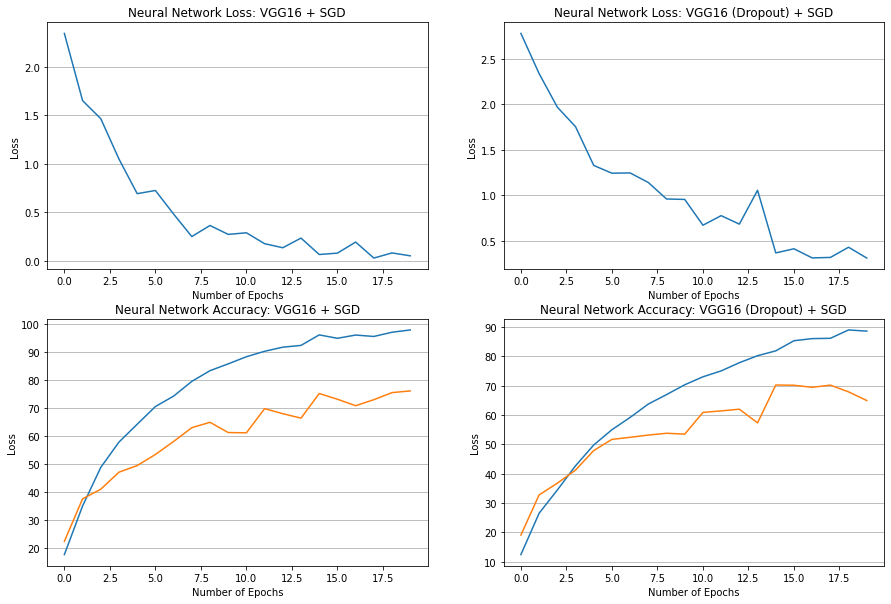

In [40]:
vgg_fig, vgg_axs = plt.subplots(2, 2, figsize=(15, 10))
vgg_axs[0,0].plot(list(map(lambda x: x[-1], vgg_loss_history)))
vgg_axs[0,0].grid(axis='y')
vgg_axs[0,0].set_title("Neural Network Loss: VGG16 + SGD")    
vgg_axs[0,0].set_xlabel("Number of Epochs")
vgg_axs[0,0].set_ylabel("Loss")
# ax1.show()

vgg_axs[0,1].plot(list(map(lambda x: x[-1], vgg_drp_loss_history)))
vgg_axs[0,1].grid(axis='y')
vgg_axs[0,1].set_title("Neural Network Loss: VGG16 (Dropout) + SGD")    
vgg_axs[0,1].set_xlabel("Number of Epochs")
vgg_axs[0,1].set_ylabel("Loss")
# ax2.show()

vgg_axs[1,0].plot(list(map(lambda x: float(x), vgg_train_acc_history)), label="Train")
vgg_axs[1,0].plot(list(map(lambda x: float(x), vgg_test_acc_history)), label="Test")
vgg_axs[1,0].grid(axis='y')
vgg_axs[1,0].set_title("Neural Network Accuracy: VGG16 + SGD")    
vgg_axs[1,0].set_xlabel("Number of Epochs")
vgg_axs[1,0].set_ylabel("Loss")

vgg_axs[1,1].plot(list(map(lambda x: float(x), vgg_drp_train_acc_history)), label="Train")
vgg_axs[1,1].plot(list(map(lambda x: float(x), vgg_drp_test_acc_history)), label="Test")
vgg_axs[1,1].grid(axis='y')
vgg_axs[1,1].set_title("Neural Network Accuracy: VGG16 (Dropout) + SGD")    
vgg_axs[1,1].set_xlabel("Number of Epochs")
vgg_axs[1,1].set_ylabel("Loss")

vgg_accuracy = evaluate(vgg, fish_test_dataset)
print(f"VGG16 Final accuracy = {vgg_accuracy / len(fish_test_set)*100:.2f}%")
vgg_drp_accuracy = evaluate(vgg_drp, fish_test_dataset)
print(f"VGG16 (Dropout) Final accuracy = {vgg_drp_accuracy / len(fish_test_set)*100:.2f}%")

# Lenet Training

In [9]:
lenet_learning_rate = 0.02
lenet_nepochs = 20
lenet_batch_size = 16

lenet_fish_train_dataset = DataLoader(fish_train_set, batch_size=lenet_batch_size)
lenet_fish_test_dataset = DataLoader(fish_test_set, batch_size=lenet_batch_size)

loss_function = nn.CrossEntropyLoss()

In [59]:
lenet_1 = LeNet(num_classes=30).to(device)
lenet_optimizer_adam = optim.Adam(lenet_1.parameters(), lr=lenet_learning_rate)

print("Training Lenet + Adam optimizer...")
# lenet_1 = lenet_1.to(device)
lenet_1.train()
lenet_loss_history_1 = []
lenet_train_acc_history_1 = []
lenet_test_acc_history_1 = []
for epoch in tqdm(range(lenet_nepochs),
                  desc=f"Epoch",
                  unit="epoch",
                  disable=False):
    loss_history, accuracy = (train_epoch(model=lenet_1, 
                                          train_data=lenet_fish_train_dataset, 
                                          LossFunction=loss_function, 
                                          optimizer=lenet_optimizer_adam))
    lenet_loss_history_1.append(loss_history)
    lenet_train_acc_history_1.append(accuracy)
    lenet_test_acc_history_1.append((evaluate(lenet_1, lenet_fish_test_dataset) / len(fish_test_set)) * 100)

    print(f"Epoch {epoch}:\ntrain loss: {lenet_loss_history_1[-1][-1]}"
          f"\ntrain acc:  {float(lenet_train_acc_history_1[-1])} test acc: {float(lenet_test_acc_history_1[-1])}")

Training Lenet + Adam optimizer...


Epoch:   5%|███▋                                                                     | 1/20 [00:28<08:54, 28.13s/epoch]

Epoch 0:
train loss: 2.544456958770752
train acc:  12.442211151123047 test acc: 18.82253646850586


Epoch:  10%|███████▎                                                                 | 2/20 [00:56<08:23, 27.99s/epoch]

Epoch 1:
train loss: 2.0306358337402344
train acc:  27.035175323486328 test acc: 32.87613296508789


Epoch:  15%|██████████▉                                                              | 3/20 [01:23<07:51, 27.75s/epoch]

Epoch 2:
train loss: 1.5928200483322144
train acc:  35.29648208618164 test acc: 39.945133209228516


Epoch:  20%|██████████████▌                                                          | 4/20 [01:50<07:22, 27.63s/epoch]

Epoch 3:
train loss: 1.4513912200927734
train acc:  42.5728645324707 test acc: 44.165435791015625


Epoch:  25%|██████████████████▎                                                      | 5/20 [02:18<06:53, 27.54s/epoch]

Epoch 4:
train loss: 1.7015297412872314
train acc:  47.27638244628906 test acc: 44.3553466796875


Epoch:  30%|█████████████████████▉                                                   | 6/20 [02:45<06:25, 27.51s/epoch]

Epoch 5:
train loss: 1.2641470432281494
train acc:  50.95477294921875 test acc: 49.03988265991211


Epoch:  35%|█████████████████████████▌                                               | 7/20 [03:13<05:57, 27.50s/epoch]

Epoch 6:
train loss: 1.4061520099639893
train acc:  53.32663345336914 test acc: 49.37750244140625


Epoch:  40%|█████████████████████████████▏                                           | 8/20 [03:40<05:30, 27.58s/epoch]

Epoch 7:
train loss: 1.3240585327148438
train acc:  56.38190841674805 test acc: 49.27199935913086


Epoch:  45%|████████████████████████████████▊                                        | 9/20 [04:08<05:03, 27.55s/epoch]

Epoch 8:
train loss: 1.000498652458191
train acc:  57.94974899291992 test acc: 50.432579040527344


Epoch:  50%|████████████████████████████████████                                    | 10/20 [04:35<04:35, 27.51s/epoch]

Epoch 9:
train loss: 1.1836451292037964
train acc:  60.160804748535156 test acc: 50.32707595825195


Epoch:  55%|███████████████████████████████████████▌                                | 11/20 [05:03<04:07, 27.49s/epoch]

Epoch 10:
train loss: 0.89803546667099
train acc:  63.055274963378906 test acc: 52.14180374145508


Epoch:  60%|███████████████████████████████████████████▏                            | 12/20 [05:30<03:39, 27.49s/epoch]

Epoch 11:
train loss: 0.7816775441169739
train acc:  63.55778884887695 test acc: 53.00696563720703


Epoch:  65%|██████████████████████████████████████████████▊                         | 13/20 [05:58<03:12, 27.51s/epoch]

Epoch 12:
train loss: 0.63227379322052
train acc:  65.12562561035156 test acc: 51.550960540771484


Epoch:  70%|██████████████████████████████████████████████████▍                     | 14/20 [06:25<02:45, 27.50s/epoch]

Epoch 13:
train loss: 0.7228593826293945
train acc:  66.07035064697266 test acc: 52.247310638427734


Epoch:  75%|██████████████████████████████████████████████████████                  | 15/20 [06:53<02:17, 27.58s/epoch]

Epoch 14:
train loss: 0.8648644685745239
train acc:  67.47738647460938 test acc: 54.27305221557617


Epoch:  80%|█████████████████████████████████████████████████████████▌              | 16/20 [07:21<01:50, 27.69s/epoch]

Epoch 15:
train loss: 0.9639006853103638
train acc:  68.44220733642578 test acc: 54.08313751220703


Epoch:  85%|█████████████████████████████████████████████████████████████▏          | 17/20 [07:48<01:22, 27.60s/epoch]

Epoch 16:
train loss: 0.8258293271064758
train acc:  69.12562561035156 test acc: 55.05380630493164


Epoch:  90%|████████████████████████████████████████████████████████████████▊       | 18/20 [08:16<00:54, 27.48s/epoch]

Epoch 17:
train loss: 0.5913193821907043
train acc:  71.03517150878906 test acc: 53.9354248046875


Epoch:  95%|████████████████████████████████████████████████████████████████████▍   | 19/20 [08:43<00:27, 27.38s/epoch]

Epoch 18:
train loss: 0.7652680277824402
train acc:  71.03517150878906 test acc: 55.9400749206543


Epoch: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [09:10<00:00, 27.54s/epoch]

Epoch 19:
train loss: 0.48530450463294983
train acc:  72.30150604248047 test acc: 54.673980712890625


In [65]:
lenet_2 = LeNet(num_classes=30).to(device)
lenet_optimizer_sgd = optim.SGD(lenet_2.parameters(), lr=lenet_learning_rate)

print("Training Lenet + SGD optimizer...")
# lenet_2 = lenet_2.to(device)
lenet_2.train()
lenet_loss_history_2 = []
lenet_train_acc_history_2 = []
lenet_test_acc_history_2 = []
for epoch in tqdm(range(lenet_nepochs),
                  desc=f"Epoch",
                  unit="epoch",
                  disable=False):
    loss_history, accuracy = (train_epoch(model=lenet_2, 
                                          train_data=lenet_fish_train_dataset, 
                                          LossFunction=loss_function, 
                                          optimizer=lenet_optimizer_sgd))
    lenet_loss_history_2.append(loss_history)
    lenet_train_acc_history_2.append(accuracy)
    lenet_test_acc_history_2.append((evaluate(lenet_2, lenet_fish_test_dataset) / len(fish_test_set)) * 100)

    print(f"Epoch {epoch}:\ntrain loss: {lenet_loss_history_2[-1][-1]}"
          f"\ntrain acc:  {float(lenet_train_acc_history_2[-1])} test acc: {float(lenet_test_acc_history_2[-1])}")

Training Lenet + SGD optimizer...


Epoch:   5%|███▋                                                                     | 1/20 [00:27<08:50, 27.91s/epoch]

Epoch 0:
train loss: 3.239281177520752
train acc:  4.341708660125732 test acc: 7.069002151489258


Epoch:  10%|███████▎                                                                 | 2/20 [00:55<08:22, 27.92s/epoch]

Epoch 1:
train loss: 2.703260660171509
train acc:  12.16080379486084 test acc: 17.197721481323242


Epoch:  15%|██████████▉                                                              | 3/20 [01:23<07:50, 27.66s/epoch]

Epoch 2:
train loss: 2.3288893699645996
train acc:  19.135677337646484 test acc: 23.57037353515625


Epoch:  20%|██████████████▌                                                          | 4/20 [01:50<07:22, 27.68s/epoch]

Epoch 3:
train loss: 2.141772508621216
train acc:  26.33165740966797 test acc: 28.381515502929688


Epoch:  25%|██████████████████▎                                                      | 5/20 [02:18<06:52, 27.53s/epoch]

Epoch 4:
train loss: 2.2077724933624268
train acc:  31.63819122314453 test acc: 32.34859848022461


Epoch:  30%|█████████████████████▉                                                   | 6/20 [02:45<06:24, 27.46s/epoch]

Epoch 5:
train loss: 2.052351951599121
train acc:  35.97990036010742 test acc: 36.14686584472656


Epoch:  35%|█████████████████████████▌                                               | 7/20 [03:12<05:56, 27.40s/epoch]

Epoch 6:
train loss: 1.8221180438995361
train acc:  39.43718719482422 test acc: 38.32032012939453


Epoch:  40%|█████████████████████████████▏                                           | 8/20 [03:40<05:28, 27.37s/epoch]

Epoch 7:
train loss: 1.722740888595581
train acc:  42.89447021484375 test acc: 42.498416900634766


Epoch:  45%|████████████████████████████████▊                                        | 9/20 [04:08<05:03, 27.59s/epoch]

Epoch 8:
train loss: 1.533639669418335
train acc:  45.82914352416992 test acc: 44.31314468383789


Epoch:  50%|████████████████████████████████████                                    | 10/20 [04:35<04:36, 27.62s/epoch]

Epoch 9:
train loss: 1.3409837484359741
train acc:  48.4824104309082 test acc: 45.748050689697266


Epoch:  55%|███████████████████████████████████████▌                                | 11/20 [05:03<04:08, 27.64s/epoch]

Epoch 10:
train loss: 1.139137625694275
train acc:  51.23617935180664 test acc: 47.288455963134766


Epoch:  60%|███████████████████████████████████████████▏                            | 12/20 [05:30<03:40, 27.57s/epoch]

Epoch 11:
train loss: 1.0990087985992432
train acc:  53.52763748168945 test acc: 47.562774658203125


Epoch:  65%|██████████████████████████████████████████████▊                         | 13/20 [05:58<03:13, 27.61s/epoch]

Epoch 12:
train loss: 1.015456199645996
train acc:  56.70351791381836 test acc: 50.896812438964844


Epoch:  70%|██████████████████████████████████████████████████▍                     | 14/20 [06:26<02:46, 27.81s/epoch]

Epoch 13:
train loss: 0.8751989603042603
train acc:  59.778892517089844 test acc: 51.44545364379883


Epoch:  75%|██████████████████████████████████████████████████████                  | 15/20 [06:54<02:19, 27.88s/epoch]

Epoch 14:
train loss: 0.799528181552887
train acc:  61.809043884277344 test acc: 51.95188522338867


Epoch:  80%|█████████████████████████████████████████████████████████▌              | 16/20 [07:22<01:51, 27.91s/epoch]

Epoch 15:
train loss: 0.5891714096069336
train acc:  63.51758575439453 test acc: 52.120697021484375


Epoch:  85%|█████████████████████████████████████████████████████████████▏          | 17/20 [07:50<01:23, 27.89s/epoch]

Epoch 16:
train loss: 0.5735527873039246
train acc:  65.16582489013672 test acc: 54.441864013671875


Epoch:  90%|████████████████████████████████████████████████████████████████▊       | 18/20 [08:18<00:55, 27.91s/epoch]

Epoch 17:
train loss: 0.594608724117279
train acc:  67.21607971191406 test acc: 54.10424041748047


Epoch:  95%|████████████████████████████████████████████████████████████████████▍   | 19/20 [08:46<00:27, 27.93s/epoch]

Epoch 18:
train loss: 0.414633572101593
train acc:  68.8241195678711 test acc: 55.792362213134766


Epoch: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [09:14<00:00, 27.73s/epoch]

Epoch 19:
train loss: 0.5177825689315796
train acc:  70.29145812988281 test acc: 53.70331573486328


Lenet + Adam Final accuracy = 54.74%
Lenet + SGD Final accuracy = 53.58%


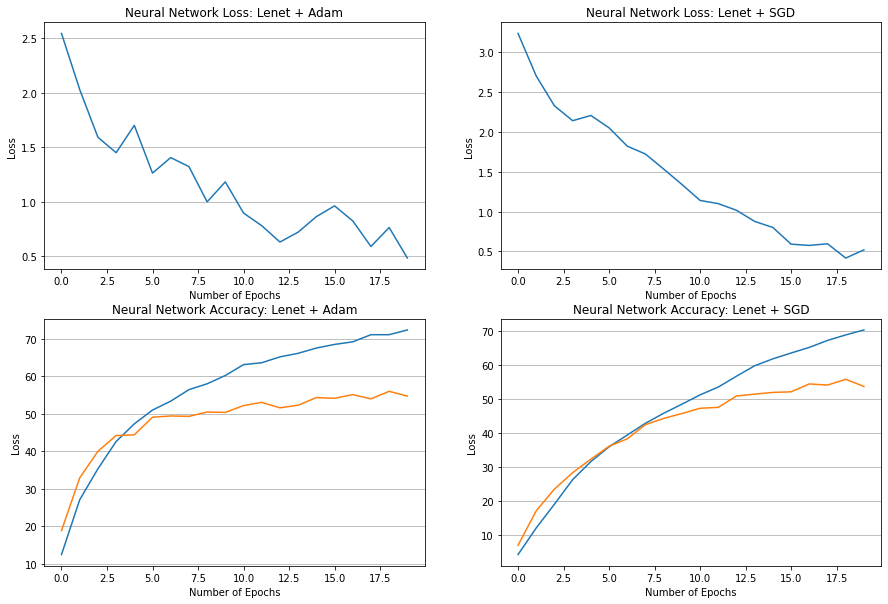

In [66]:
lenet_fig, lenet_axs = plt.subplots(2, 2, figsize=(15, 10))
lenet_axs[0,0].plot(list(map(lambda x: x[-1], lenet_loss_history_1)))
lenet_axs[0,0].grid(axis='y')
lenet_axs[0,0].set_title("Neural Network Loss: Lenet + Adam")    
lenet_axs[0,0].set_xlabel("Number of Epochs")
lenet_axs[0,0].set_ylabel("Loss")
# ax1.show()

lenet_axs[0,1].plot(list(map(lambda x: x[-1], lenet_loss_history_2)))
lenet_axs[0,1].grid(axis='y')
lenet_axs[0,1].set_title("Neural Network Loss: Lenet + SGD")    
lenet_axs[0,1].set_xlabel("Number of Epochs")
lenet_axs[0,1].set_ylabel("Loss")
# ax2.show()

lenet_axs[1,0].plot(list(map(lambda x: float(x), lenet_train_acc_history_1)), label="Train")
lenet_axs[1,0].plot(list(map(lambda x: float(x), lenet_test_acc_history_1)), label="Test")
lenet_axs[1,0].grid(axis='y')
lenet_axs[1,0].set_title("Neural Network Accuracy: Lenet + Adam")    
lenet_axs[1,0].set_xlabel("Number of Epochs")
lenet_axs[1,0].set_ylabel("Loss")

lenet_axs[1,1].plot(list(map(lambda x: float(x), lenet_train_acc_history_2)), label="Train")
lenet_axs[1,1].plot(list(map(lambda x: float(x), lenet_test_acc_history_2)), label="Test")
lenet_axs[1,1].grid(axis='y')
lenet_axs[1,1].set_title("Neural Network Accuracy: Lenet + SGD")    
lenet_axs[1,1].set_xlabel("Number of Epochs")
lenet_axs[1,1].set_ylabel("Loss")

lenet_accuracy_1 = evaluate(lenet_1, fish_test_dataset)
print(f"Lenet + Adam Final accuracy = {lenet_accuracy_1 / len(fish_test_set)*100:.2f}%")
lenet_accuracy_2 = evaluate(lenet_2, fish_test_dataset)
print(f"Lenet + SGD Final accuracy = {lenet_accuracy_2 / len(fish_test_set)*100:.2f}%")

<br><span style="color:black;font-size:35px">**AlexNet**</span>

In [68]:
alex_learning_rate = 1e-2
alex_batch_size = 32
alex_momentum = 0.9
alex_nepochs = 20
alex_pt_nepochs = 5

alex_transform = T.Compose([T.Resize(size=(227,227)),
#                             T.CenterCrop(224),
                            T.RandomHorizontalFlip(),
                            T.ToTensor(), 
                            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                           ])

alex_fish_train_set = FishDataset(FILEPATH, 
                                  train=True, 
                                  shuffle=True, 
                                  transform=alex_transform)
alex_fish_test_set = FishDataset(FILEPATH, 
                                 train=False, 
                                 shuffle=False, 
                                 transform=alex_transform)

alex_train_dataset = DataLoader(alex_fish_train_set, batch_size=alex_batch_size)
alex_test_dataset = DataLoader(alex_fish_test_set, batch_size=alex_batch_size)

alex_loss_function = nn.CrossEntropyLoss()

In [69]:
# alex = AlexNet(nout=30).to(device)
print(device)
alex = torch.hub.load("pytorch/vision:v0.6.0", "alexnet", pretrained=False)
alex.classifier[4] = nn.Linear(4096, 1024)
alex.classifier[6] = nn.Linear(1024, 30)
alex = alex.to(device)
# alex.fc = nn.Sequential(nn.Linear(2048, num_classes), nn.Sigmoid())
print(alex)

alex_optimizer_sgd = optim.SGD(alex.parameters(), lr=alex_learning_rate)

alex.train()
alex_loss_history = []
alex_train_acc_history = []
alex_test_acc_history = []
for epoch in tqdm(range(alex_nepochs),
                  desc=f"Epoch",
                  unit="epoch",
                  disable=False):
    loss_history, accuracy = (train_epoch(model=alex, 
                                          train_data=alex_train_dataset, 
                                          LossFunction=alex_loss_function, 
                                          optimizer=alex_optimizer_sgd))
    alex_loss_history.append(loss_history)
    alex_train_acc_history.append(accuracy)
    alex_test_acc_history.append((evaluate(alex, alex_test_dataset) / len(alex_fish_test_set)) * 100)

    print(f"Epoch {epoch}:\ntrain loss: {alex_loss_history[-1][-1]}"
          f"\ntrain acc:  {float(alex_train_acc_history[-1])} test acc: {float(alex_test_acc_history[-1])}")

cuda


Using cache found in C:\Users\Evant/.cache\torch\hub\pytorch_vision_v0.6.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Epoch:   5%|███▋                                                                     | 1/20 [00:44<13:58, 44.14s/epoch]

Epoch 0:
train loss: 3.394979238510132
train acc:  3.3165829181671143 test acc: 3.6716606616973877


Epoch:  10%|███████▎                                                                 | 2/20 [01:28<13:12, 44.01s/epoch]

Epoch 1:
train loss: 3.3881547451019287
train acc:  4.08040189743042 test acc: 4.009284496307373


Epoch:  15%|██████████▉                                                              | 3/20 [02:12<12:27, 43.98s/epoch]

Epoch 2:
train loss: 3.38344669342041
train acc:  4.1005024909973145 test acc: 4.832242965698242


Epoch:  20%|██████████████▌                                                          | 4/20 [02:55<11:43, 43.95s/epoch]

Epoch 3:
train loss: 3.3492960929870605
train acc:  4.221105575561523 test acc: 4.325807094573975


Epoch:  25%|██████████████████▎                                                      | 5/20 [03:39<10:58, 43.93s/epoch]

Epoch 4:
train loss: 3.33186936378479
train acc:  3.95979905128479 test acc: 5.401983261108398


Epoch:  30%|█████████████████████▉                                                   | 6/20 [04:23<10:14, 43.91s/epoch]

Epoch 5:
train loss: 3.3086485862731934
train acc:  4.422110557556152 test acc: 5.1909685134887695


Epoch:  35%|█████████████████████████▌                                               | 7/20 [05:07<09:31, 43.95s/epoch]

Epoch 6:
train loss: 3.328472375869751
train acc:  5.165829181671143 test acc: 7.82865571975708


Epoch:  40%|█████████████████████████████▏                                           | 8/20 [05:51<08:48, 44.02s/epoch]

Epoch 7:
train loss: 3.1180357933044434
train acc:  7.798995018005371 test acc: 9.41126823425293


Epoch:  45%|████████████████████████████████▊                                        | 9/20 [06:35<08:04, 44.03s/epoch]

Epoch 8:
train loss: 3.0444769859313965
train acc:  11.678391456604004 test acc: 14.813251495361328


Epoch:  50%|████████████████████████████████████                                    | 10/20 [07:19<07:20, 44.01s/epoch]

Epoch 9:
train loss: 2.9566335678100586
train acc:  15.919597625732422 test acc: 18.31610107421875


Epoch:  55%|███████████████████████████████████████▌                                | 11/20 [08:04<06:36, 44.08s/epoch]

Epoch 10:
train loss: 3.017613649368286
train acc:  19.05527687072754 test acc: 20.426250457763672


Epoch:  60%|███████████████████████████████████████████▏                            | 12/20 [08:48<05:52, 44.06s/epoch]

Epoch 11:
train loss: 3.06791090965271
train acc:  22.91457176208496 test acc: 18.928043365478516


Epoch:  65%|██████████████████████████████████████████████▊                         | 13/20 [09:32<05:08, 44.08s/epoch]

Epoch 12:
train loss: 3.041322946548462
train acc:  26.150753021240234 test acc: 19.244565963745117


Epoch:  70%|██████████████████████████████████████████████████▍                     | 14/20 [10:16<04:24, 44.05s/epoch]

Epoch 13:
train loss: 2.749370574951172
train acc:  29.447235107421875 test acc: 29.64760398864746


Epoch:  75%|██████████████████████████████████████████████████████                  | 15/20 [11:00<03:40, 44.04s/epoch]

Epoch 14:
train loss: 2.6540298461914062
train acc:  32.98492431640625 test acc: 32.728424072265625


Epoch:  80%|█████████████████████████████████████████████████████████▌              | 16/20 [11:44<02:56, 44.05s/epoch]

Epoch 15:
train loss: 2.3569564819335938
train acc:  37.025123596191406 test acc: 37.72947692871094


Epoch:  85%|█████████████████████████████████████████████████████████████▏          | 17/20 [12:28<02:12, 44.03s/epoch]

Epoch 16:
train loss: 2.3103041648864746
train acc:  41.085426330566406 test acc: 39.839630126953125


Epoch:  90%|████████████████████████████████████████████████████████████████▊       | 18/20 [13:12<01:28, 44.04s/epoch]

Epoch 17:
train loss: 2.127457857131958
train acc:  44.22110366821289 test acc: 46.35999298095703


Epoch:  95%|████████████████████████████████████████████████████████████████████▍   | 19/20 [13:56<00:44, 44.06s/epoch]

Epoch 18:
train loss: 2.1913390159606934
train acc:  48.20100402832031 test acc: 46.19118118286133


Epoch: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [14:40<00:00, 44.03s/epoch]

Epoch 19:
train loss: 1.9860117435455322
train acc:  51.09547805786133 test acc: 48.913272857666016


In [58]:
# alex = AlexNet(nout=30).to(device)
print(device)
alex<br><span style="color:black;font-size:25px">**No Pretraining**</span>_pt = torch.hub.load("pytorch/vision:v0.6.0", "alexnet", pretrained=True)
alex_pt.classifier[4] = nn.Linear(4096, 1024)
alex_pt.classifier[6] = nn.Linear(1024, 30)
alex_pt = alex_pt.to(device)
# alex.fc = nn.Sequential(nn.Linear(2048, num_classes), nn.Sigmoid())
print(alex_pt)

alex_pt_optimizer_sgd = optim.SGD(alex_pt.parameters(), lr=alex_learning_rate)

alex_pt.train()
alex_pt_loss_history = []
alex_pt_train_acc_history = []
alex_pt_test_acc_history = []
for epoch in tqdm(range(alex_pt_nepochs),
                  desc=f"Epoch",
                  unit="epoch",
                  disable=False):
    loss_history, accuracy = (train_epoch(model=alex_pt, 
                                          train_data=alex_train_dataset, 
                                          LossFunction=alex_loss_function, 
                                          optimizer=alex_pt_optimizer_sgd))
    alex_pt_loss_history.append(loss_history)
    alex_pt_train_acc_history.append(accuracy)
    alex_pt_test_acc_history.append((evaluate(alex_pt, alex_test_dataset) / len(alex_fish_test_set)) * 100)

    print(f"Epoch {epoch}:\ntrain loss: {alex_pt_loss_history[-1][-1]}"
          f"\ntrain acc:  {float(alex_pt_train_acc_history[-1])} test acc: {float(alex_pt_test_acc_history[-1])}")

cuda


Using cache found in C:\Users\Evant/.cache\torch\hub\pytorch_vision_v0.6.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Epoch:  20%|██████████████▊                                                           | 1/5 [00:45<03:03, 45.98s/epoch]

Epoch 0:
train loss: 1.2344225645065308
train acc:  45.68844223022461 test acc: 82.82337951660156


Epoch:  40%|█████████████████████████████▌                                            | 2/5 [01:30<02:15, 45.32s/epoch]

Epoch 1:
train loss: 0.6122767329216003
train acc:  80.9648208618164 test acc: 87.59231567382812


Epoch:  60%|████████████████████████████████████████████▍                             | 3/5 [02:16<01:30, 45.34s/epoch]

Epoch 2:
train loss: 0.6413240432739258
train acc:  86.53266143798828 test acc: 89.85018157958984


Epoch:  80%|███████████████████████████████████████████████████████████▏              | 4/5 [03:01<00:45, 45.33s/epoch]

Epoch 3:
train loss: 0.3062150776386261
train acc:  90.05024719238281 test acc: 91.09516906738281


Epoch: 100%|██████████████████████████████████████████████████████████████████████████| 5/5 [03:46<00:00, 45.36s/epoch]

Epoch 4:
train loss: 0.2692074179649353
train acc:  91.59799194335938 test acc: 91.6227035522461


AlexNet Final accuracy = 49.08%
AlexNet (Pretrained) Final accuracy = 91.41%


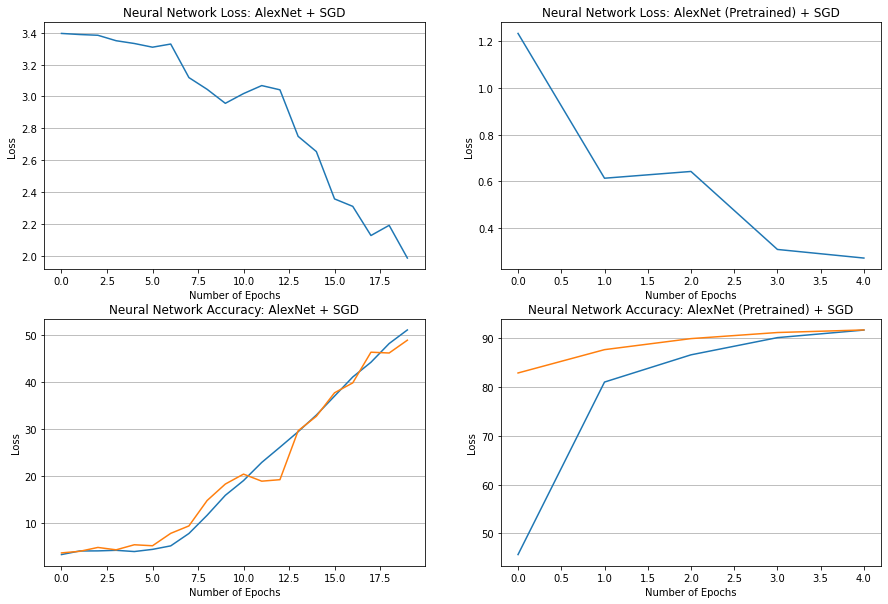

In [70]:
alex_fig, alex_axs = plt.subplots(2, 2, figsize=(15, 10))
alex_axs[0,0].plot(list(map(lambda x: x[-1], alex_loss_history)))
alex_axs[0,0].grid(axis='y')
alex_axs[0,0].set_title("Neural Network Loss: AlexNet + SGD")    
alex_axs[0,0].set_xlabel("Number of Epochs")
alex_axs[0,0].set_ylabel("Loss")

alex_axs[0,1].plot(list(map(lambda x: x[-1], alex_pt_loss_history)))
alex_axs[0,1].grid(axis='y')
alex_axs[0,1].set_title("Neural Network Loss: AlexNet (Pretrained) + SGD")    
alex_axs[0,1].set_xlabel("Number of Epochs")
alex_axs[0,1].set_ylabel("Loss")

alex_axs[1,0].plot(list(map(lambda x: float(x), alex_train_acc_history)), label="Train")
alex_axs[1,0].plot(list(map(lambda x: float(x), alex_test_acc_history)), label="Test")
alex_axs[1,0].grid(axis='y')
alex_axs[1,0].set_title("Neural Network Accuracy: AlexNet + SGD")    
alex_axs[1,0].set_xlabel("Number of Epochs")
alex_axs[1,0].set_ylabel("Loss")

alex_axs[1,1].plot(list(map(lambda x: float(x), alex_pt_train_acc_history)), label="Train")
alex_axs[1,1].plot(list(map(lambda x: float(x), alex_pt_test_acc_history)), label="Test")
alex_axs[1,1].grid(axis='y')
alex_axs[1,1].set_title("Neural Network Accuracy: AlexNet (Pretrained) + SGD")    
alex_axs[1,1].set_xlabel("Number of Epochs")
alex_axs[1,1].set_ylabel("Loss")

alex_accuracy = evaluate(alex, alex_test_dataset)
print(f"AlexNet Final accuracy = {alex_accuracy / len(alex_fish_test_set)*100:.2f}%")
alex_pt_accuracy = evaluate(alex_pt, alex_test_dataset)
print(f"AlexNet (Pretrained) Final accuracy = {alex_pt_accuracy / len(alex_fish_test_set)*100:.2f}%")